In [1]:
import os
import time
import pickle
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder
from EncoderClassifier import EncoderClassifier

In [2]:
data = MNISTData()
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [3]:
load_from_stem = "./autoencoder_models/1558731906/"
load_model_from = os.path.join(load_from_stem, "ae.pt")
load_layers_from = os.path.join(load_from_stem, "layer_sizes.pkl")

In [4]:
with open(load_layers_from, 'rb') as f:
    layer_sizes = pickle.load(f)
layer_sizes = layer_sizes[1:]
print(layer_sizes)
ae = AutoEncoder(layer_sizes)
ae.load_state_dict(torch.load(load_model_from))

[256, 64, 10]


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
summary(ae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
            Linear-7                   [-1, 64]             704
              ReLU-8                   [-1, 64]               0
            Linear-9                  [-1, 256]          16,640
             ReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 784]         201,488
          Sigmoid-12                  [-1, 784]               0
Total params: 436,890
Trainable params: 436,890
Non-trainable params: 0
-------------------------------

In [6]:
ec = EncoderClassifier(ae.encoder, ae.get_encoding_size())
summary(ec, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
              ReLU-6                   [-1, 10]               0
            Linear-7                 [-1, 1000]          11,000
           Dropout-8                 [-1, 1000]               0
            Linear-9                   [-1, 10]          10,010
Total params: 239,068
Trainable params: 21,010
Non-trainable params: 218,058
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.91
Estimated Total Size (MB): 0.94
--------------------------------------

In [7]:
save_directory = "./encoderclassifier_models"
def save_model(model, model_name="ec.pt", message=None):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    subdirectory_name = str(int(time.time()))
    subdirectory_path = os.path.join(save_directory, subdirectory_name)
    if not os.path.exists(subdirectory_path):
        os.makedirs(subdirectory_path)
    save_path = os.path.join(subdirectory_path, model_name)
    torch.save(model.state_dict(), save_path)
    if message is not None:
        message_save_path = os.path.join(subdirectory_path, "message.txt")
        with open(message_save_path, 'w') as f:
            f.write(message + "\n")
    print("everything was saved to %s" % subdirectory_path)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ec.parameters(), lr=.01, momentum=.9)

In [9]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ec(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 91.851
[1,   400] loss: 70.344
[2,   200] loss: 63.721
[2,   400] loss: 49.585
[3,   200] loss: 32.678
[3,   400] loss: 25.768
[4,   200] loss: 17.796
[4,   400] loss: 15.013
[5,   200] loss: 10.320
[5,   400] loss: 6.474
[6,   200] loss: 3.537
[6,   400] loss: 2.160
[7,   200] loss: 1.213
[7,   400] loss: 1.083
[8,   200] loss: 1.009
[8,   400] loss: 1.032
[9,   200] loss: 0.961
[9,   400] loss: 0.979
[10,   200] loss: 0.969
[10,   400] loss: 1.015
Finished Training


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = ec(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 69 %


In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    outputs = ec(example_data)
    _, predicted = torch.max(outputs.data, 1)
print(predicted)

tensor([7, 3, 1, 0, 4, 1, 4, 4, 8, 9, 0, 0, 4, 0, 3, 3, 9, 7, 3, 4, 7, 6, 2, 3,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 3, 1, 1, 7, 4, 1, 3, 3, 3, 2,
        4, 4, 6, 3, 0, 3, 2, 0, 4, 1, 9, 7, 7, 2, 9, 3, 7, 9, 0, 4, 3, 0, 7, 0,
        0, 8, 1, 7, 3, 8, 9, 7, 9, 6, 2, 9, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        3, 3, 0, 9, 6, 0, 3, 4, 8, 4, 0, 1, 9, 4, 3, 1, 3, 9, 7, 9, 4, 4, 9, 8,
        3, 9, 9, 6, 9, 4, 0, 5])


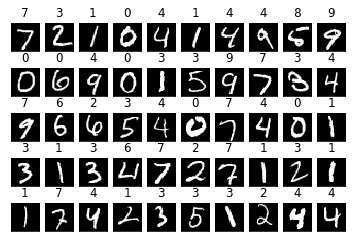

In [12]:
# see images and their labels
fig = plt.figure()
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("%d" % predicted[i])
    plt.xticks([])
    plt.yticks([])

In [13]:
# if you would like to write some notes, save it as a string and pass it to the 'message' parameter of save_model
# if you don't set message to None
message = '''This used the encoder from 1558731906.
with 10 epochs it managed to get 69% accuracy.'''

In [14]:
save_model(ec, message=message)

everything was saved to ./encoderclassifier_models/1558732844
